## ***Initialization***
Import packages. First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-y0ozbx09
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-y0ozbx09
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265564 sha256=e28960b3f124b77c55471b6a945e14c8b1bdbbd550039d8f1a8222c19824059c
  Stored in directory: /tmp/pip-ephem-wheel-cache-nt4ti54t/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

# Fill in the Google Drive path
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'directed_study_Yuliang_Zhu/dataset/CWFID/dataset-1.0/'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_COLAB = 'directed_study_Yuliang_Zhu/colab/'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_PRED = 'directed_study_Yuliang_Zhu/pred_results/'
GOOGLE_DRIVE_DATASET_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_COLAB_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_COLAB)
GOOGLE_DRIVE_ANNOTATION_PATH = GOOGLE_DRIVE_DATASET_PATH + "annotations/"
GOOGLE_DRIVE_PRED_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_PRED)

# use another drive
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Research/directed_study_Yuliang_Zhu-20201008T200633Z-001/directed_study_Yuliang_Zhu/dataset/CWFID/dataset-1.0/'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_COLAB = 'Research/directed_study_Yuliang_Zhu-20201008T200633Z-001/directed_study_Yuliang_Zhu/colab/'
# GOOGLE_DRIVE_DATASET_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# GOOGLE_DRIVE_COLAB_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_COLAB)
# GOOGLE_DRIVE_ANNOTATION_PATH = GOOGLE_DRIVE_DATASET_PATH + "annotations/"

print(GOOGLE_DRIVE_DATASET_PATH)
print(GOOGLE_DRIVE_COLAB_PATH)
print(GOOGLE_DRIVE_ANNOTATION_PATH)
print(GOOGLE_DRIVE_PRED_PATH)

drive/My Drive/directed_study_Yuliang_Zhu/dataset/CWFID/dataset-1.0/
drive/My Drive/directed_study_Yuliang_Zhu/colab/
drive/My Drive/directed_study_Yuliang_Zhu/dataset/CWFID/dataset-1.0/annotations/
drive/My Drive/directed_study_Yuliang_Zhu/pred_results/


In [5]:
# for the purpose of importing detection package

import sys
sys.path.append(GOOGLE_DRIVE_DATASET_PATH)
sys.path.append(GOOGLE_DRIVE_COLAB_PATH)
# sys.path.append("/home/angrypiggy/Documents/Fall2020/")

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import yaml
import detection
import cv2
import matplotlib.patches as patches

import json
from pathlib import Path
from math import trunc
import base64
from io import BytesIO
import random

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 6

In [7]:
if torch.cuda.is_available():
  print("Good to go!")

Good to go!


## CocoDataset Class

In [8]:
class CocoDataset():
  def __init__(self, annotation_path, image_dir):
    self.annotation_path = annotation_path
    self.image_dir = image_dir
    
    # Customize these segmentation colors if you like, if there are more segmentations
    # than colors in an image, the remaining segmentations will default to white
    self.colors = ['red', 'green', 'blue', 'yellow', ]
    
    json_file = open(self.annotation_path)
    self.coco = json.load(json_file)
    json_file.close()
    
    self._process_info()
    self._process_licenses()
    self._process_categories()
    self._process_images()
    self._process_segmentations()
  
  def _process_info(self):
    self.info = self.coco['info']
      
  def _process_licenses(self):
    self.licenses = self.coco['licenses']
      
  def _process_categories(self):
    self.categories = dict()
    self.super_categories = dict()
    
    for category in self.coco['categories']:
      cat_id = category['id']
      super_category = category['supercategory']
      
      # Add category to categories dict
      if cat_id not in self.categories:
        self.categories[cat_id] = category
      else:
        print(f'ERROR: Skipping duplicate category id: {category}')
      
      # Add category id to the super_categories dict
      if super_category not in self.super_categories:
        self.super_categories[super_category] = {cat_id}
      else:
        self.super_categories[super_category] |= {cat_id} # e.g. {1, 2, 3} |= {4} => {1, 2, 3, 4}

  def _process_images(self):
    self.images = dict()
    for image in self.coco['images']:
      image_id = image['id']
      if image_id not in self.images:
        self.images[image_id] = image
      else:
        print(f'ERROR: Skipping duplicate image id: {image}')
              
  def _process_segmentations(self):
    self.segmentations = dict()
    for segmentation in self.coco['annotations']:
      image_id = segmentation['image_id']
      if image_id not in self.segmentations:
        self.segmentations[image_id] = []
      self.segmentations[image_id].append(segmentation)
      
  def display_info(self):
    print('Dataset Info')
    print('='*80)
    for key, item in self.info.items():
      print(f'  {key}: {item}')
          
  def display_licenses(self):
    print('Licenses')
    print('='*80)
    for license in self.licenses:
      for key, item in license.items():
        print(f'  {key}: {item}')
              
  def display_categories(self):
    print('Categories')
    print('='*80)
    for sc_name, set_of_cat_ids in self.super_categories.items():
      print(f'  super_category: {sc_name}')
      for cat_id in set_of_cat_ids:
        print(f'    id {cat_id}: {self.categories[cat_id]["name"]}')
        
      print('')
          
  def display_image(self, image_id, show_bbox=True, show_polys=True, show_crowds=True):
    print('Image')
    print('='*80)
    
    # Print image info
    image = self.images[image_id]
    for key, val in image.items():
      print(f'  {key}: {val}')
    print('='*80)
    # Open the image
    image_path = Path(self.image_dir) / image['file_name']
    image = PILImage.open(image_path)
    
    buffer = BytesIO()
    image.save(buffer, format='PNG')
    buffer.seek(0)
    
    data_uri = base64.b64encode(buffer.read()).decode('ascii')
    image_path = "data:image/png;base64,{0}".format(data_uri)
    
    # Calculate the size and adjusted display size
    max_width = 600
    image_width, image_height = image.size
    adjusted_width = min(image_width, max_width)
    adjusted_ratio = adjusted_width / image_width
    adjusted_height = adjusted_ratio * image_height
    
    # Create bounding boxes and polygons
    bboxes = dict()
    polygons = dict()
    rle_regions = dict()
    seg_colors = dict()
    
    # print("printing color-object correspondence.")
    for i, seg in enumerate(self.segmentations[image_id]):
      if i < len(self.colors):
        seg_colors[seg['id']] = self.colors[i]
      else:
        seg_colors[seg['id']] = self.colors[random.randint(0,3)]
          
      print(f'  {seg_colors[seg["id"]]}: {self.categories[seg["category_id"]]["name"]}', i)
      
      bboxes[seg['id']] = np.multiply(seg['bbox'], adjusted_ratio).astype(int)
      
      if seg['iscrowd'] == 0:
        polygons[seg['id']] = []
        for seg_points in seg['segmentation']:
          seg_points = np.multiply(seg_points, adjusted_ratio).astype(int)
          polygons[seg['id']].append(str(seg_points).lstrip('[').rstrip(']'))
      else:
        # Decode the RLE
        px = 0
        rle_list = []
        for j, counts in enumerate(seg['segmentation']['counts']):
          if counts < 0:
            print(f'ERROR: One of the counts was negative, treating as 0: {counts}')
            counts = 0
          
          if j % 2 == 0:
            # Empty pixels
            px += counts
          else:
            # Create one or more vertical rectangles
            x1 = trunc(px / image_height)
            y1 = px % image_height
            px += counts
            x2 = trunc(px / image_height)
            y2 = px % image_height
            
            if x2 == x1: # One vertical column
              line = [x1, y1, 1, (y2 - y1)]
              line = np.multiply(line, adjusted_ratio)
              rle_list.append(line)
            else: # Two or more columns
              # Insert left-most line first
              left_line = [x1, y1, 1, (image_height - y1)]
              left_line = np.multiply(left_line, adjusted_ratio)
              rle_list.append(left_line)
              
              # Insert middle lines (if needed)
              lines_spanned = x2 - x1 + 1
              if lines_spanned > 2: # Two columns won't have a middle
                middle_lines = [(x1 + 1), 0, lines_spanned - 2, image_height]
                middle_lines = np.multiply(middle_lines, adjusted_ratio)
                rle_list.append(middle_lines)
                  
              # Insert right-most line
              right_line = [x2, 0, 1, y2]
              right_line = np.multiply(right_line, adjusted_ratio)
              rle_list.append(right_line)
                    
        if len(rle_list) > 0:
          rle_regions[seg['id']] = rle_list
                            
                        
    
    # Draw the image
    html = '<div class="container" style="position:relative;">'
    html += f'<img src="{str(image_path)}" style="position:relative; top:0px; left:0px; width:{adjusted_width}px;">'
    html += '<div class="svgclass">'
    html += f'<svg width="{adjusted_width}" height="{adjusted_height}">'
    
    # Draw shapes on image
    if show_polys:
      for seg_id, points_list in polygons.items():
        for points in points_list:
          html += f'<polygon points="{points}" \
            style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; fill-opacity:0.5; stroke-width:1;" />'
    
    if show_crowds:
      for seg_id, line_list in rle_regions.items():
        for line in line_list:
          html += f'<rect x="{line[0]}" y="{line[1]}" width="{line[2]}" height="{line[3]}" \
            style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; \
            fill-opacity:0.5; stroke-opacity:0.5" />'
    
    if show_bbox:
      for seg_id, bbox in bboxes.items():
        html += f'<rect x="{bbox[0]}" y="{bbox[1]}" width="{bbox[2]}" height="{bbox[3]}" \
          style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; fill-opacity:0" />'
    
    html += '</svg>'
    html += '</div>'
    html += '</div>'
    html += '<style>'
    html += '.svgclass {position: absolute; top:0px; left: 0px}'
    html += '</style>'
    
    return html
      
      
  def display_segmentation(self, img_id):
    # print(self.segmentations[img_id])
    return self.segmentations[img_id]

In [9]:
instances_json_path = "/content/drive/MyDrive/directed_study_Yuliang_Zhu/dataset/output/coco_instances.json"
images_path = "/content/drive/MyDrive/directed_study_Yuliang_Zhu/dataset/output/images/"
coco_dataset = CocoDataset(instances_json_path, images_path)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info
  description: yl 200
  url: yl
  version: 1.1
  year: 2020
  contributor: yl
  date_created: 12/18/2020
Licenses
  url: yl
  id: 0
  name: yl
Categories
  super_category: weeds
    id 1: Kale

  super_category: crops
    id 2: Lettuce
    id 3: Radish
    id 4: Spinach
    id 5: Brussels_sprouts



In [10]:
idx = 12
print(len(coco_dataset.display_segmentation(idx)))
print(coco_dataset.display_segmentation(idx)[0].keys())
print(coco_dataset.display_segmentation(idx)[43]['category_id'])

50
dict_keys(['segmentation', 'iscrowd', 'image_id', 'category_id', 'id', 'bbox', 'area'])
5


## ***Dataset Visualization***
Choose the index to visualize training and mask samples.

In [ ]:
# sample image
GOOGLE_DRIVE_DATASET_PATH = "/home/angrypiggy/Documents/Fall2020/research/coco/synth_dataset/output/"

img_idx_train = "2"
train_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'images', img_idx_train.zfill(8) + '.png'))
print('image type', type(train_sample))
plt.imshow(train_sample)
plt.axis('off')
plt.title("Training image %d" %int(img_idx_train), size=12)
train_sample = np.array(train_sample)
print('training sample shape:', train_sample.shape)
# print('train_sample_unique', np.unique(train_sample))
plt.show()

mask sample shape: (1043, 1862, 3)
mask_sample_unique [  0  11  20  32  34  35  42  46  47  50  60  69  71  80  85  87  92  99
 100 107 122 124 127 128 134 139 140 142 143 144 150 152 154 160 165 170
 173 178 183 184 188 189 192 205 215 218 220 230 232 233 238 240 250 251
 252 255]


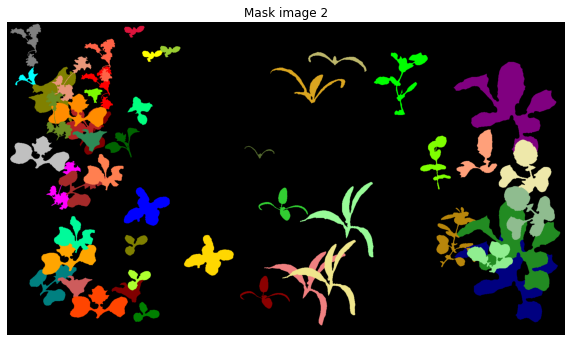

In [ ]:
# sample binary mask (background or plant)

img_idx_mask = "2"
mask_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'masks', img_idx_mask.zfill(8) + '.png'))

plt.imshow(mask_sample)
plt.axis('off')
plt.title("Mask image %d" %int(img_idx_mask), size=12)
mask_sample = np.array(mask_sample)
print('mask sample shape:', mask_sample.shape)
print('mask_sample_unique', np.unique(mask_sample))
plt.show()

annotation_sample shape: (966, 1296, 3)
annotation_sample_unique [  0 255]
X [255   0   0] <class 'numpy.ndarray'> (3,)


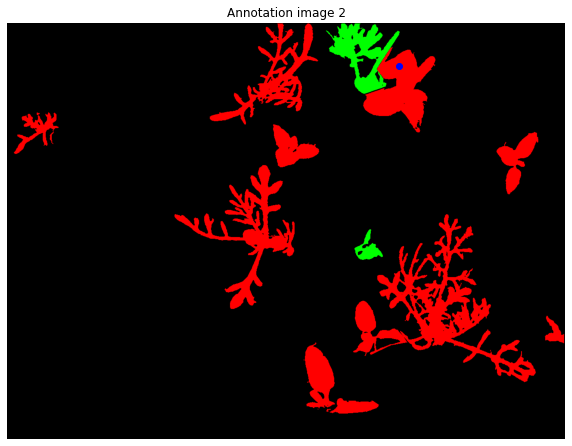

In [ ]:
# sample annotation mask (green - plant; red - weed)

img_idx_mask = "2"
annotation_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'annotations', img_idx_mask.zfill(3) + '_annotation.png')).convert("RGB")

plt.imshow(annotation_sample)

plt.axis('off')
plt.title("Annotation image %d" %int(img_idx_mask), size=12)

annotation_sample = np.array(annotation_sample)
print('annotation_sample shape:', annotation_sample.shape)
print('annotation_sample_unique', np.unique(annotation_sample))
x_test = 100
y_test = 910
print('X', annotation_sample[x_test][y_test], type(annotation_sample[y_test][x_test]), annotation_sample[y_test][x_test].shape)
plt.plot(y_test, x_test, 'bo')
plt.show()

Test our mask conversion where [R G B] elemens are converted to corresponding class labels.

converted_mask_sample shape: (966, 1296)
converted_mask_sample unique [0 1 2]


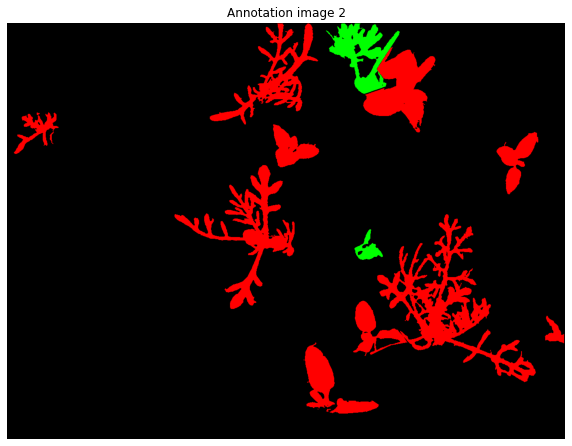

In [ ]:
# [R G B] -> 0 1 2

img_idx_converted_annotation = "2"
converted_mask_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'converted_annotations', img_idx_converted_annotation.zfill(3) + '_annotation.png'))

plt.axis('off')
plt.title("Annotation image %d" %int(img_idx_converted_annotation), size=12)
converted_mask_sample.putpalette([
    0, 0, 0, # black background
    0, 255, 0, # index 1 is green
    255, 0, 0, # index 2 is red
])
plt.imshow(converted_mask_sample)
converted_mask_sample = np.array(converted_mask_sample)
print('converted_mask_sample shape:', converted_mask_sample.shape)
print('converted_mask_sample unique', np.unique(converted_mask_sample))

Now to test the converted instance masks. [R G B] to instance label (1, 2, ..., num_polygons)

instance_mask_sample shape: (966, 1296)
instance_mask_sample unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


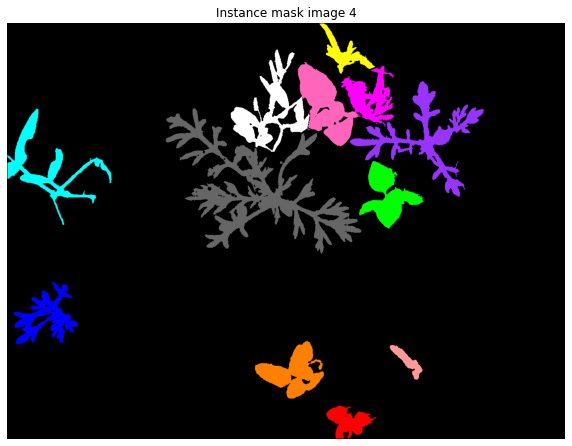

In [ ]:
img_idx_instance_mask = "4"
instance_mask_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'instance_masks', img_idx_instance_mask.zfill(3) + '_instance.png'))

plt.axis('off')
plt.title("Instance mask image %d" %int(img_idx_instance_mask), size=12)
instance_mask_sample.putpalette([
    0, 0, 0, # black background
    0, 255, 0, # index 1 is green
    255, 0, 0, # index 2 is red
    0, 0, 255, # 3
    255, 128, 0, # 4
    255, 153, 153, # 5
    153, 51, 255, # 6
    102, 102, 102, # 7
    0, 255, 255, # 8
    255, 255, 0, # 9
    255, 0, 255, # 10
    255, 255, 255, # 11
    255, 102, 187, # 12
    160, 160, 160, # 13
    255, 153, 255, # 14 
    0, 102, 51, # 15
    153, 153, 255, # 16
    204, 204, 0, # 17 max
])
plt.imshow(instance_mask_sample, cmap=None)
instance_mask_sample = np.array(instance_mask_sample)
print('instance_mask_sample shape:', instance_mask_sample.shape)
print('instance_mask_sample unique', np.unique(instance_mask_sample))

In [ ]:
for i in range(1, 61):
  instance_mask_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'instance_masks', str(i).zfill(3) + '_instance.png'))
  instance_mask_sample = np.array(instance_mask_sample)
  print('instance_mask_sample unique', np.unique(instance_mask_sample))

Distinguish background and plant. (True -- background, Flase -- plant)

In [ ]:
# ===========Test Code===========
print('mask_sample_unique', np.unique(mask_sample))
mask_sample[0][0]
print('True', len(np.where(mask_sample)[0]), '--Background')
print('False', len(np.where(mask_sample == False)[0]), '--Plant')
# ===========End of Test Code===========

mask_sample_unique [False  True]
True 1109426 --Background
False 142510 --Plant


## ***OLD Dataset Class Definition***
Define the class and implement internal methods for the ease of using dataloader.

In [ ]:
# define the dataset class - OLD

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

# GOOGLE_DRIVE_ANNOTATION_PATH = GOOGLE_DRIVE_DATASET_PATH + "annotations"
# All subclasses should overwrite __getitem__(), supporting fetching a data 
# sample for a given key. Subclasses could also optionally overwrite __len__(), 
# which is expected to return the size of the dataset
class CWFIDataset_OLD(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
    # self.masks = sorted([filename for filename in os.listdir(GOOGLE_DRIVE_ANNOTATION_PATH) if filename.endswith('.png')])
    
  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    mask_path = os.path.join(self.root, "masks", self.masks[idx])
    # mask_path = os.path.join(self.root, "annotations", self.masks[idx])
    img = Image.open(img_path).convert("RGB") # w*h*3
    mask = Image.open(mask_path) 
    mask_png = mask

    mask = np.array(mask) # w*h*3, 
    # gonna convert this to w*h. [0 0 0] -> 0, [0 255 0] ->1, [255 0 0] -> 2
    

    # instances are encoded as crop or weed
    obj_ids = np.unique(mask) # only contains False or True  [False  True] - Plant vs Bg
    # second id is the background, so remove it
    obj_ids = obj_ids[:-1]
    # print('obj_ids:', obj_ids) obj_ids: [False]
    # print('obj_ids shape:', obj_ids[:, None, None].shape)   obj_ids shape: (1, 1, 1)
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None] # obj_ids[:, None, None] 1*1*1 // masks (1, 966, 1296)
    # print('masks shape:', masks.shape) masks shape: (1, 966, 1296)

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids) # 1 here
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.zeros((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
  
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
# define the dataset class - NEW

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

GOOGLE_DRIVE_CONVERTED_ANNOTATION_PATH = GOOGLE_DRIVE_DATASET_PATH + "converted_annotations/"
# All subclasses should overwrite __getitem__(), supporting fetching a data 
# sample for a given key. Subclasses could also optionally overwrite __len__(), 
# which is expected to return the size of the dataset
class CWFIDataset_OLD2(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "instance_masks"))))
    self.yamls = sorted([filename for filename in os.listdir(os.path.join(root, "annotations")) if filename.endswith('.yaml')])
    self.boxes = np.loadtxt(os.path.join(GOOGLE_DRIVE_DATASET_PATH, "boxes.txt")) # (60, 17*4)
    self.labels = np.loadtxt(os.path.join(GOOGLE_DRIVE_DATASET_PATH, "labels.txt")) # (60, 17)

    
  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    mask_path = os.path.join(self.root, "instance_masks", self.masks[idx])
    img = Image.open(img_path).convert("RGB") # w*h*3
    mask = Image.open(mask_path)

    mask = np.array(mask)
    # instances are encoded as background, crop or weed
    obj_ids = np.unique(mask) # [0, 1, 2 ,3, ..., n]
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None] # obj_ids[:, None, None] n*1*1 // masks (n, 966, 1296)

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids) # n here
    boxes = []
    labels = []
    yaml_path = os.path.join(self.root, "annotations", self.yamls[idx])
    # print('yaml path', yaml_path)
    with open(yaml_path) as f:
      data = yaml.load(f, Loader=yaml.Loader)

    for i in range(len(data['annotation'])):
      xs_local = data['annotation'][i]['points']['x']
      ys_local = data['annotation'][i]['points']['y']
      label_polygon = data['annotation'][i]['type']

      # background - 0, plant - 1, weed - 2
      if label_polygon == 'weed':
        labels.append(2)
      elif label_polygon == 'crop':
        labels.append(1)

      #  remove single point masks
      if type(xs_local) == list and type(ys_local) == list:
        x_min = min(xs_local)
        x_max = max(xs_local)
        y_min = min(ys_local)
        y_max = max(ys_local)
        boxes.append([x_min, y_min, x_max, y_max])
    
    # TODO: sequence may also matter
    # probably boxes number should align with labels
    # boxes = boxes[:num_objs]

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    # labels = torch.ones((num_objs,), dtype=torch.int64)
    # labels = torch.tensor([1, 2], dtype=torch.int64)
    labels = torch.tensor(labels)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
  
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

## ***Dataset Class Definition***
Define the class and implement internal methods for the ease of using dataloader.

In [11]:
GOOGLE_DRIVE_DATASET_PATH = "/home/angrypiggy/Documents/Fall2020/research/coco/synth_dataset/output/"

GOOGLE_DRIVE_DATASET_PATH

'/home/angrypiggy/Documents/Fall2020/research/coco/synth_dataset/output/'

In [12]:
# define the dataset class - NEW

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

GOOGLE_DRIVE_CONVERTED_ANNOTATION_PATH = GOOGLE_DRIVE_DATASET_PATH + "converted_annotations/"
# All subclasses should overwrite __getitem__(), supporting fetching a data 
# sample for a given key. Subclasses could also optionally overwrite __len__(), 
# which is expected to return the size of the dataset
class CWFIDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "instance_masks"))))
    self.yamls = sorted([filename for filename in os.listdir(os.path.join(root, "annotations")) if filename.endswith('.yaml')])
    self.boxes = np.loadtxt(os.path.join(GOOGLE_DRIVE_DATASET_PATH, "boxes.txt")).reshape(60, 17, 4) # (60, 17, 4)
    self.labels = np.loadtxt(os.path.join(GOOGLE_DRIVE_DATASET_PATH, "labels.txt"), dtype=np.int64) # (60, 17) (1s, 2s) 1-crop, 2-weed
    # self.labels = self.labels - 1

    
  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    mask_path = os.path.join(self.root, "instance_masks", self.masks[idx])
    img = Image.open(img_path).convert("RGB") # w*h*3
    mask = Image.open(mask_path)

    mask = np.array(mask)
    # instances are encoded as background, crop or weed
    obj_ids = np.unique(mask) # [0, 1, 2 ,3, ..., n]
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set of binary masks
    masks = mask == obj_ids[:, None, None] # obj_ids[:, None, None] n*1*1 // masks (n, 966, 1296)

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids) # n
    boxes = self.boxes[idx][:num_objs]
    labels = self.labels[idx][:num_objs]

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
  
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [13]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
    # self.yamls = sorted([filename for filename in os.listdir(os.path.join(root, "annotations")) if filename.endswith('.yaml')])
    json_file = open(os.path.join(root, "coco_instances.json"))
    self.coco = json.load(json_file)
    json_file.close()
    # self.boxes = np.loadtxt(os.path.join(GOOGLE_DRIVE_DATASET_PATH, "boxes.txt")).reshape(60, 17, 4) # (60, 17, 4)
    # self.labels = np.loadtxt(os.path.join(GOOGLE_DRIVE_DATASET_PATH, "labels.txt"), dtype=np.int64) # (60, 17) (1s, 2s) 1-crop, 2-weed
    # self.labels = self.labels - 1
    self.mask_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255),
                        (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0), (0, 128, 0), (128, 0, 128),
                        (0, 128, 128), (0, 0, 128), (128, 0, 0), (139, 0, 0), (165, 42, 42), (178, 34, 34),
                        (220, 20, 60), (255, 99, 71), (255, 127, 80), (205, 92, 92), (240, 128, 128), (233, 150, 122),
                        (255, 160, 122), (255, 69, 0), (255, 140, 0), (255,165,0), (255,215,0), (184,134,11), (218,165,32),
                        (238,232,170), (189,183,107), (240,230,140), (128,128,0), (154,205,50), (85,107,47), (107,142,35),
                        (124,252,0), (127,255,0), (173,255,47), (0,100,0), 	(34,139,34), 	(50,205,50), (144,238,144),
                        (152,251,152), (143,188,143),	(0,250,154), (0,255,127), (46,139,87), (102,205,170), (60,179,113),
                        (32,178,170), (47,79,79),	(0,139,139), (224,255,255)]
    self.color_to_idx = dict()
    for i, c in enumerate(self.mask_colors):
      self.color_to_idx[c] = i+1 # not background
    
  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    mask_path = os.path.join(self.root, "masks", self.masks[idx])
    img = Image.open(img_path).convert("RGB") # w*h*3
    mask = Image.open(mask_path)

    mask = np.array(mask)
    # print('shape', mask.shape)
    # width, height, _ = mask.shape
    # mask_copy = np.zeros((width, height))
    # for i in range(width):
    #   for j in range(height):
    #     if mask[i][j][0] == 0 and mask[i][j][1] == 0 and mask[i][j][2] == 0:
    #       continue
    #     mask_copy[i][j] = self.color_to_idx[tuple(mask[i][j])]
    # mask = mask_copy
    # instances are encoded as background, crop or weed
    obj_ids = np.unique(mask) # [0, 1, 2 ,3, ..., n]
    # print('mask unique', obj_ids)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # print('here', mask.shape, obj_ids)
    # split the color-encoded mask into a set of binary masks
    masks = mask == obj_ids[:, None, None] # obj_ids[:, None, None] n*1*1 // masks (n, 966, 1296)
    # print('here', masks.shape, masks)
    # get bounding box coordinates for each mask
    # num_objs = len(obj_ids) # n
    num_objs = len(coco_dataset.display_segmentation(idx))
    # boxes = self.boxes[idx][:num_objs]
    # labels = self.labels[idx][:num_objs]
    # len(coco_dataset.display_segmentation(idx))
    boxes, labels = [], []
    for i in range(num_objs):
      # 'segmentation', 'iscrowd', 'image_id', 'category_id', 'id', 'bbox', 'area'
      seg = coco_dataset.display_segmentation(idx)[i]
      temp_box = [seg['bbox'][0], seg['bbox'][1], seg['bbox'][0] + seg['bbox'][2], seg['bbox'][1] + seg['bbox'][3] ]
      boxes.append(temp_box)
      labels.append(seg['category_id'])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
  
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = CWFIDataset(GOOGLE_DRIVE_DATASET_PATH)
# dataset.masks
print('dataset size:', len(dataset))
# print('dataset[5]:', dataset[5])
# print('dataset.image', dataset.imgs)
# print('unique', torch.unique(dataset[0][1]['masks']), dataset[0][1]['masks'].shape)

In [ ]:
idx_test = 7
print('boxes', dataset[idx_test][1]['boxes'].shape)
print('labels', dataset[idx_test][1]['labels'].shape)
print(dataset[idx_test][1]['labels'])
print('masks', dataset[idx_test][1]['masks'].shape)
print('image_id', dataset[idx_test][1]['image_id'].shape)
print('area', dataset[idx_test][1]['area'].shape)
print('iscrowd', dataset[idx_test][1]['iscrowd'].shape)

boxes torch.Size([8, 4])
labels torch.Size([8])
tensor([2, 2, 2, 2, 1, 2, 1, 2])
masks torch.Size([8, 966, 1296])
image_id torch.Size([1])
area torch.Size([8])
iscrowd torch.Size([8])


In [14]:
my_dataset = MyDataset("/content/drive/MyDrive/directed_study_Yuliang_Zhu/dataset/output")
len(my_dataset)

200

In [15]:
idx_test = 17
ret = my_dataset[idx_test][1]
print('boxes', ret['boxes'].shape)
print('labels', ret['labels'].shape)
print(ret['labels'])
print('masks', ret['masks'].shape)
print('image_id', ret['image_id'].shape)
print('area', ret['area'].shape)
print('iscrowd', ret['iscrowd'].shape)

boxes torch.Size([50, 4])
labels torch.Size([50])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 3,
        3, 3])
masks torch.Size([50, 1043, 1862])
image_id torch.Size([1])
area torch.Size([50])
iscrowd torch.Size([50])


## ***Visualizing Bounding Boxes***
Try to draw the bounding box of plants with yaml. The first one is a bad representation of the bounding boxes.

boxes location tensor([[524., 354., 675., 546.],
        [533.,   1., 716., 153.],
        [533., 658., 676., 815.],
        [228.,  42., 487., 203.],
        [ 24.,   6., 105.,  46.],
        [555., 800., 719., 952.]]) torch.Size([6, 4])


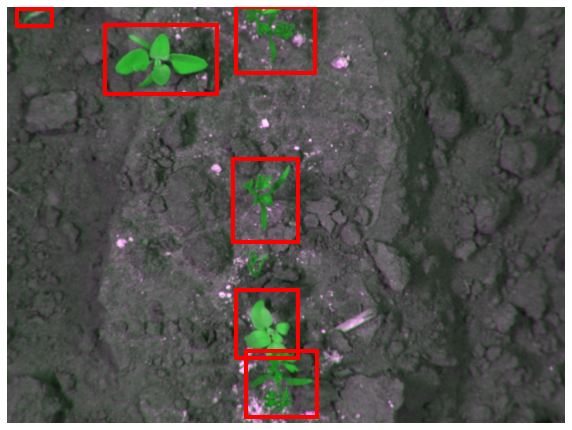

w, h tensor(164.) tensor(152.)


In [ ]:
# naive approach ========> not any more

import matplotlib.patches as patches

img_sample_idx = 43
fig, ax = plt.subplots(1)
box_location = dataset[img_sample_idx][1]['boxes']
print('boxes location', box_location, box_location.shape) # xmin ymin xmax ymax

for i in range(box_location.shape[0]):
  width = box_location[i][2] - box_location[i][0]
  height = box_location[i][3] - box_location[i][1]
  rect = patches.Rectangle((box_location[i][0]-1, box_location[i][1]-1), width, height, linewidth=4, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

ax.imshow(dataset[img_sample_idx][0])
ax.axis('off')

# test overlap
# query_point = (373.0, 345.0)
# plt.plot(query_point, 'bo')

plt.show()
print('w, h', width, height)

Load the YAML files.

In [ ]:
# Get the yaml file name list

GOOGLE_DRIVE_ANNOTATION_PATH = GOOGLE_DRIVE_DATASET_PATH + "annotations"
# print(sorted(filename in os.listdir(GOOGLE_DRIVE_ANNOTATION_PATH) if filename.endswith('.yaml')))
os.listdir(GOOGLE_DRIVE_ANNOTATION_PATH)
YAML_LIST = sorted([filename for filename in os.listdir(GOOGLE_DRIVE_ANNOTATION_PATH) if filename.endswith('.yaml')])
print('YAML LIST', YAML_LIST)

YAML LIST ['001_annotation.yaml', '002_annotation.yaml', '003_annotation.yaml', '004_annotation.yaml', '005_annotation.yaml', '006_annotation.yaml', '007_annotation.yaml', '008_annotation.yaml', '009_annotation.yaml', '010_annotation.yaml', '011_annotation.yaml', '012_annotation.yaml', '013_annotation.yaml', '014_annotation.yaml', '015_annotation.yaml', '016_annotation.yaml', '017_annotation.yaml', '018_annotation.yaml', '019_annotation.yaml', '020_annotation.yaml', '021_annotation.yaml', '022_annotation.yaml', '023_annotation.yaml', '024_annotation.yaml', '025_annotation.yaml', '026_annotation.yaml', '027_annotation.yaml', '028_annotation.yaml', '029_annotation.yaml', '030_annotation.yaml', '031_annotation.yaml', '032_annotation.yaml', '033_annotation.yaml', '034_annotation.yaml', '035_annotation.yaml', '036_annotation.yaml', '037_annotation.yaml', '038_annotation.yaml', '039_annotation.yaml', '040_annotation.yaml', '041_annotation.yaml', '042_annotation.yaml', '043_annotation.yaml', 

Read the polygon data and plot bounding boxes for individual plants.

In [ ]:
# Load and read a yaml file
img_idx_annotation = 42
with open(GOOGLE_DRIVE_ANNOTATION_PATH + '/' + YAML_LIST[img_idx_annotation]) as f:
  data = yaml.load(f, Loader=yaml.Loader)
  print('data', data)
  print('data filename', data['filename'])
  print('data annotation', data['annotation'])
  print('data length', len(data))
  print('num of polygons', len(data['annotation']))
  print('data annotation', data['annotation'])
  print('dict annotation first x', data["annotation"][0]['points']['x'])
  print('dict annotation first y', data["annotation"][0]['points']['y'])

fig, ax = plt.subplots(1)
xs = []
ys = []
boxes = []
for i in range(len(data['annotation'])):
  xs_local = data['annotation'][i]['points']['x']
  ys_local = data['annotation'][i]['points']['y']

  x_min = min(xs_local)
  y_min = min(ys_local)
  x_max = max(xs_local)
  y_max = max(ys_local)

  xs.append(xs_local)
  ys.append(ys_local)
  boxes.append([x_min, y_min, x_max, y_max])

  width = x_max - x_min
  height = y_max - y_min
  # rect = patches.Rectangle((x_min-1, y_min-1), width, height, linewidth=4, edgecolor='r', facecolor='none')

  if data['annotation'][i]['type'] == 'weed':
    plt.plot(xs_local + [xs_local[0], xs_local[-1]], ys_local + [ys_local[0], ys_local[-1]], 'ro-')
    # rect = patches.Rectangle((x_min-1, y_min-1), width, height, linewidth=4, edgecolor='r', facecolor='none')
    # ax.axis('off')
    # ax.add_patch(rect)
  elif data['annotation'][i]['type'] == 'crop':
    plt.plot(xs_local + [xs_local[0], xs_local[-1]], ys_local + [ys_local[0], ys_local[-1]], 'yo-')
    # rect = patches.Rectangle((x_min-1, y_min-1), width, height, linewidth=4, edgecolor='y', facecolor='none')
    # ax.axis('off')
    # ax.add_patch(rect)
# plt.plot(x0, y0, [x0[0], x0[-1]], [y0[0], y0[-1]], x1, y1, 'o-')
# ax.axis('off')
plt.xlim(0, 1296)
plt.ylim(0, 966)
plt.gca().invert_yaxis()
plt.imshow(dataset[img_idx_annotation][0])
plt.plot([373, 587], [345, 248], 'bo')
plt.show()

NameError: ignored

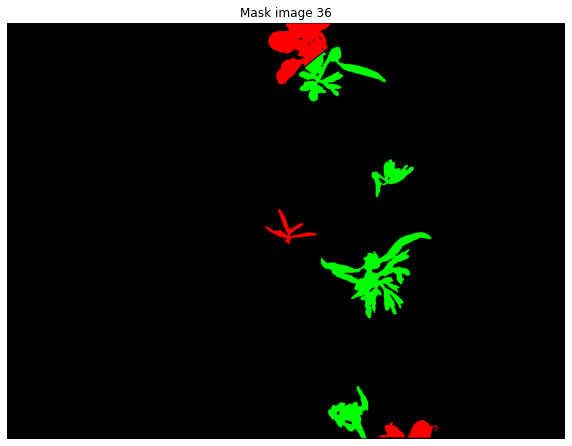

annotation_sample shape: (966, 1296, 3)
annotation_sample_unique [  0 255]


In [ ]:
img_idx_annotation_str = str(img_idx_annotation+1)
annotation_sample = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'annotations', img_idx_annotation_str.zfill(3) + '_annotation.png'))

plt.imshow(annotation_sample)
plt.axis('off')
plt.title("Mask image %d" %int(img_idx_annotation), size=12)
plt.show()
annotation_sample = np.array(annotation_sample)
print('annotation_sample shape:', annotation_sample.shape)
print('annotation_sample_unique', np.unique(annotation_sample))

## ***Model Acquicition***
In our case, we want to fine-tune from a pre-trained model.

In [16]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [17]:
# model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print('in_features', in_features)
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    print('in_features_mask', in_features_mask)
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## ***Training and evaluation functions***
That's it, this will make model be ready to be trained and evaluated on our custom dataset.



In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

Instead, for the purpose of saving modified scripts, we load the files from the package stored in the subfolder in the same dirctory.

In [18]:
from detection.engine import train_one_epoch, evaluate
import detection.utils as utils
import detection.transforms as T



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [19]:
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

## ***Putting everything together***

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [20]:
GOOGLE_DRIVE_DATASET_PATH = "/content/drive/MyDrive/directed_study_Yuliang_Zhu/dataset/output"
# use our dataset and defined transformations
# dataset = CWFIDataset(GOOGLE_DRIVE_DATASET_PATH, get_transform(train=True))
# dataset_test = CWFIDataset(GOOGLE_DRIVE_DATASET_PATH, get_transform(train=False))
dataset = MyDataset(GOOGLE_DRIVE_DATASET_PATH, get_transform(train=True))
dataset_test = MyDataset(GOOGLE_DRIVE_DATASET_PATH, get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# train_val_split_path = GOOGLE_DRIVE_DATASET_PATH + 'train_test_split.yaml'
# with open(train_val_split_path) as f:
#   indices = yaml.load(f, Loader=yaml.Loader)
# indices['test'] = indices['test'][:10] + indices['test'][11:]
# indices['test'] = (np.array(indices['test'])- 1).tolist()
# indices['train'] = (np.array(indices['train']) - 1).tolist() # 1 based -> 0 based

dataset = torch.utils.data.Subset(dataset, indices[:-40]) # 40
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:]) # 20
# dataset = torch.utils.data.Subset(dataset, indices['train']) # 40
# dataset_test = torch.utils.data.Subset(dataset_test, indices['test']) # 20

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

# our dataset has three classes - background crop, weed
num_classes = 6

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0005,
#                             momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.0005, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0.000005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=70,
                                               gamma=0.1)

in_features 1024
in_features_mask 256


And now try to train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
num_epochs = 20

loss_history = {'loss': [],
                'loss_classifier': [], 
                'loss_box_reg': [],
                'loss_mask': [],
                'loss_objectness': [],
                'loss_rpn_box_reg': []}

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, loss_history, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:06:15  lr: 0.000013  loss: 0.8484 (0.8484)  loss_classifier: 0.2599 (0.2599)  loss_box_reg: 0.4356 (0.4356)  loss_mask: 0.0255 (0.0255)  loss_objectness: 0.0639 (0.0639)  loss_rpn_box_reg: 0.0635 (0.0635)  time: 9.3961  data: 7.7417  max mem: 7759
Epoch: [0]  [10/40]  eta: 0:03:56  lr: 0.000141  loss: 0.8544 (0.8647)  loss_classifier: 0.2548 (0.2549)  loss_box_reg: 0.4356 (0.4331)  loss_mask: 0.0446 (0.0472)  loss_objectness: 0.0478 (0.0463)  loss_rpn_box_reg: 0.0549 (0.0831)  time: 7.8847  data: 6.2212  max mem: 7759
Epoch: [0]  [20/40]  eta: 0:02:49  lr: 0.000269  loss: 0.8107 (0.8262)  loss_classifier: 0.2415 (0.2420)  loss_box_reg: 0.4244 (0.4251)  loss_mask: 0.0506 (0.0529)  loss_objectness: 0.0341 (0.0392)  loss_rpn_box_reg: 0.0504 (0.0670)  time: 8.4119  data: 6.7482  max mem: 7759
Epoch: [0]  [30/40]  eta: 0:01:32  lr: 0.000398  loss: 0.8193 (0.8453)  loss_classifier: 0.2376 (0.2464)  loss_box_reg: 0.4335 (0.4316)  loss_mask: 0.0506 (0.0514)  loss_ob

## ***Save and load the model and checkpoints***


Save the model.

In [ ]:
a = 1

In [ ]:
save_addr = GOOGLE_DRIVE_COLAB_PATH + "model/model_12_18_2020.pt"
torch.save(model.state_dict(), save_addr)
print(f'Saved to: {save_addr}')
#Later to restore:
# model.load_state_dict(torch.load(GOOGLE_DRIVE_COLAB_PATH))
# model.eval()

Saved to: drive/My Drive/directed_study_Yuliang_Zhu/colab/model/model_12_18_2020.pt


Save the training checkpoint.

In [ ]:
checkpoint = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    # 'loss_history': loss_history,
}
save_addr_ckp = GOOGLE_DRIVE_COLAB_PATH + "model/checkpoint_11_24_2020.pt"
torch.save(checkpoint, save_addr_ckp)
print(f'Saved to: {save_addr_ckp}')
# model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])

Saved to: drive/My Drive/directed_study_Yuliang_Zhu/colab/model/checkpoint_11_24_2020.pt


Loading the model.

In [23]:
model.load_state_dict(torch.load(GOOGLE_DRIVE_COLAB_PATH + "model/model_12_18_2020.pt"))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [ ]:
loss_history.clear()
checkpoint = torch.load(GOOGLE_DRIVE_COLAB_PATH + "model/checkpoint_11_11_2020.pt")
# loss_history.load_state_dict(torch.load(GOOGLE_DRIVE_COLAB_PATH + "save/checkpoint_11_11_2020.pt"))
# loss_history.load_state_dict(checkpoint['loss_history'])
# type(checkpoint)
# checkpoint['loss_history']
checkpoint.keys()

dict_keys(['epoch', 'state_dict', 'optimizer'])

## ***Plot loss history***


In [ ]:
GOOGLE_DRIVE_PRED_PATH

'drive/My Drive/directed_study_Yuliang_Zhu/pred_results/'

In [ ]:
print('training steps:', len(loss_history['loss']))
print('losses:', loss_history.keys())
# save loss history, change the folder name based on date!
prefix = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_25_2020_wd_5", "loss_history")
# prefix = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_23_2020", "lr_0.0000005")

np.savetxt(os.path.join(prefix, "loss.txt"), loss_history['loss'])
np.savetxt(os.path.join(prefix, "loss_classifier.txt"), loss_history['loss_classifier'])
np.savetxt(os.path.join(prefix, "loss_box_reg.txt"), loss_history['loss_box_reg'])
np.savetxt(os.path.join(prefix, "loss_mask.txt"), loss_history['loss_mask'])
np.savetxt(os.path.join(prefix, "loss_objectness.txt"), loss_history['loss_objectness'])
np.savetxt(os.path.join(prefix, "loss_rpn_box_reg.txt"), loss_history['loss_rpn_box_reg'])
print(f'Loss saved to path: {prefix}')

training steps: 210
losses: dict_keys(['loss', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'])
Loss saved to path: drive/My Drive/directed_study_Yuliang_Zhu/pred_results/11_25_2020_wd_5/loss_history


Text(0, 0.5, 'Loss')

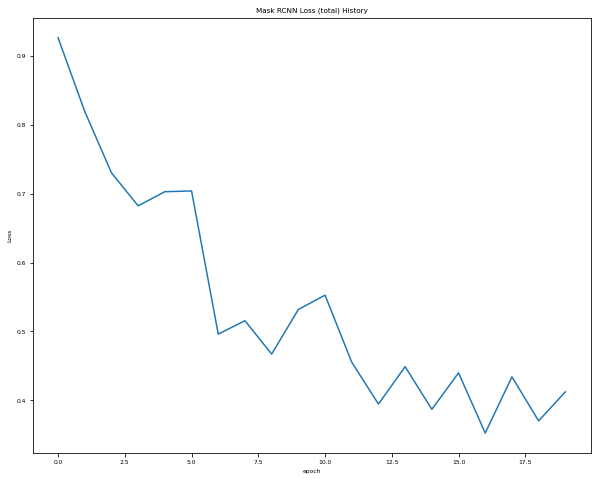

In [ ]:
plt.plot(np.arange(len(loss_history['loss'])), loss_history['loss'])
plt.title('Mask RCNN Loss (total) History')
plt.xlabel('epoch')
plt.ylabel('Loss')
# len(loss_history['loss'])

In [ ]:
plt.plot(np.arange(len(loss_history['loss'])), loss_history['loss_classifier'])
plt.title('Mask RCNN Classifier Loss History')
plt.xlabel('epoch')
plt.ylabel('Loss')

NameError: ignored

Text(0, 0.5, 'Loss')

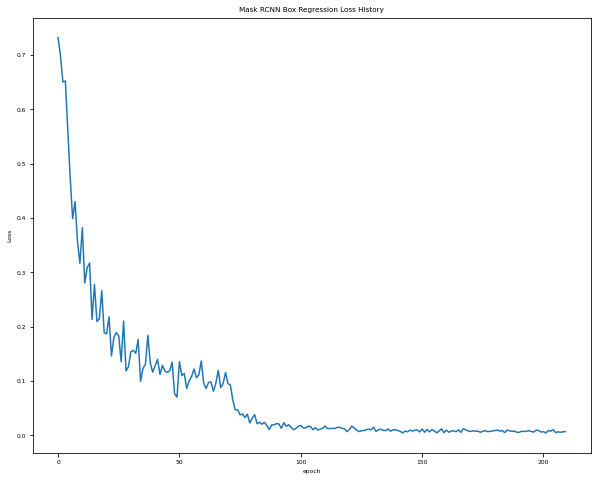

In [ ]:
plt.plot(np.arange(len(loss_history['loss'])), loss_history['loss_box_reg'])
plt.title('Mask RCNN Box Regression Loss History')
plt.xlabel('epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

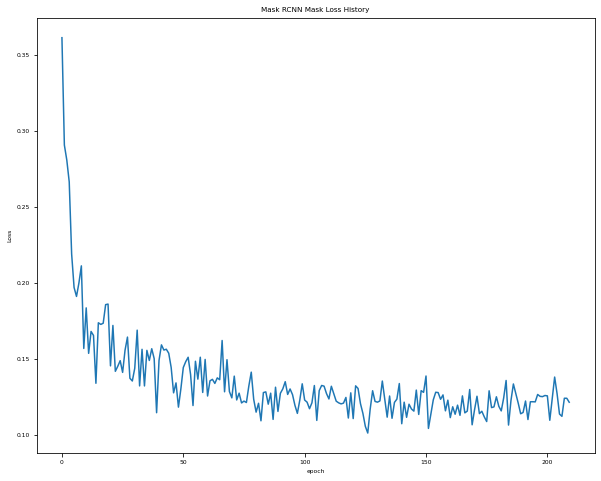

In [ ]:
plt.plot(np.arange(len(loss_history['loss'])), loss_history['loss_mask'])
plt.title('Mask RCNN Mask Loss History')
plt.xlabel('epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

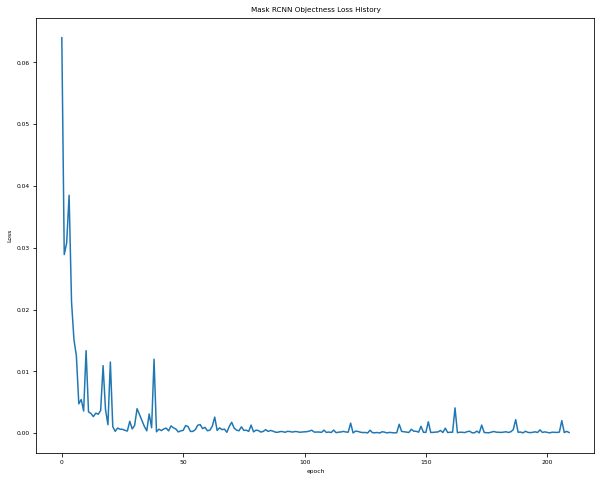

In [ ]:
plt.plot(np.arange(len(loss_history['loss'])), loss_history['loss_objectness'])
plt.title('Mask RCNN Objectness Loss History')
plt.xlabel('epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

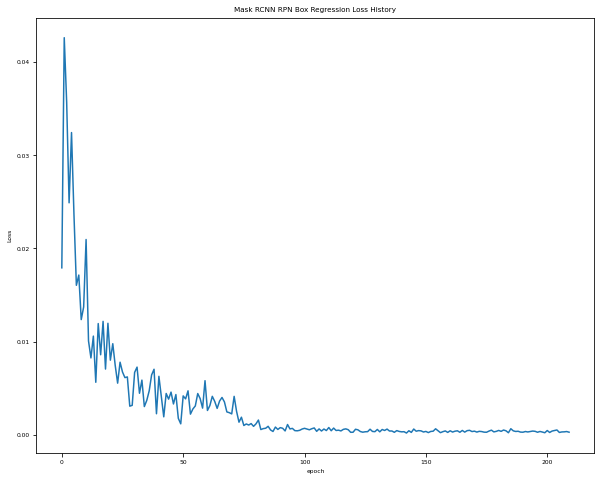

In [ ]:
plt.plot(np.arange(len(loss_history['loss'])), loss_history['loss_rpn_box_reg'])
plt.title('Mask RCNN RPN Box Regression Loss History')
plt.xlabel('epoch')
plt.ylabel('Loss')

Compare loss curves. sgd vs adam

Text(0, 0.5, 'training loss')

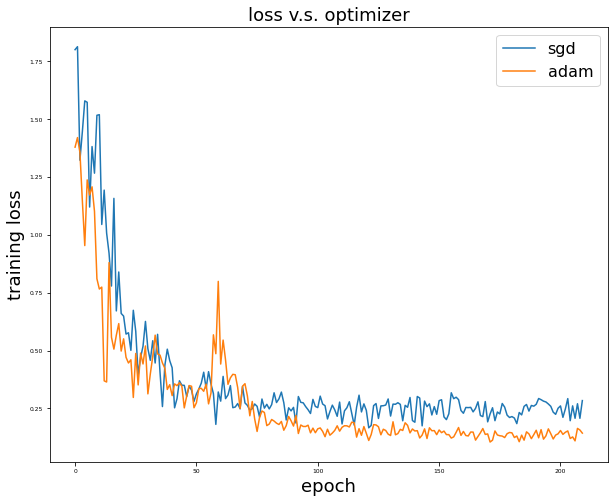

In [ ]:
# 'loss', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'
loss_category = 'loss'
prefix_sgd = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_19_2020", "loss_history")
loss_sgd = np.loadtxt(prefix_sgd + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_sgd)), loss_sgd, label="sgd")

prefix_adam = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_18_2020", "loss_history")
loss_adam = np.loadtxt(prefix_adam + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_adam)), loss_adam, label="adam")

plt.legend(loc="upper right", prop={'size': 16})
plt.title(loss_category + " v.s. optimizer", size=18)
plt.xlabel("epoch", size=18)
plt.ylabel("training loss", size=18)

batch size 2 vs 4.

Text(0, 0.5, 'training loss')

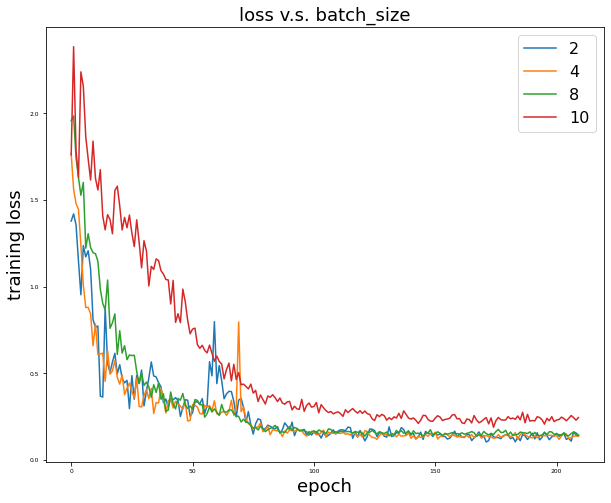

In [ ]:
# 'loss', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'
loss_category = 'loss'
prefix_2 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_18_2020", "loss_history")
loss_2 = np.loadtxt(prefix_2 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_2)), loss_2, label="2")

prefix_4 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_23_2020", "loss_history")
loss_4 = np.loadtxt(prefix_4 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_4)), loss_4, label="4")

prefix_8 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_24_2020", "loss_history")
loss_8 = np.loadtxt(prefix_8 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_8)), loss_8, label="8")

prefix_10 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_24_2020_bs_10", "loss_history")
loss_10 = np.loadtxt(prefix_10 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_10)), loss_10, label="10")

plt.legend(loc="upper right", prop={'size': 16})
plt.title(loss_category + " v.s. batch_size", size=18)
plt.xlabel("epoch", size=18)
plt.ylabel("training loss", size=18)

Compare lr's.

Text(0.5, 1.0, 'loss v.s. learning rate')

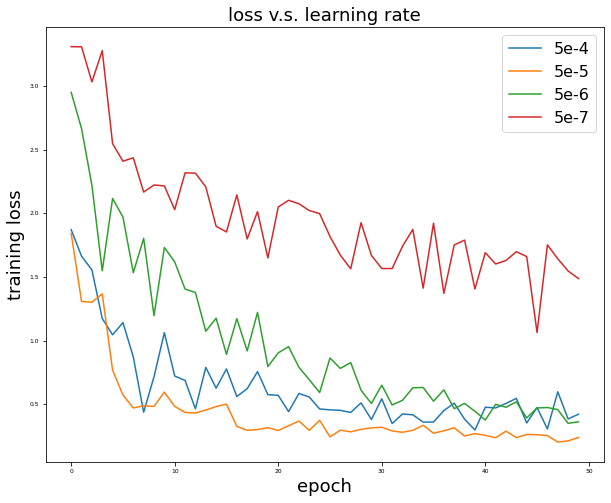

In [ ]:
# 'loss', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'
loss_category = 'loss'
# prefix_3 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_20_2020", "lr_0.005")
# loss_3 = np.loadtxt(prefix_3 + '/' + loss_category + '.txt')
# plt.plot(np.arange(len(loss_3)), loss_3, label="5e-3")

prefix_4 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_20_2020", "lr_0.0005")
loss_4 = np.loadtxt(prefix_4 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_4)), loss_4, label="5e-4")

prefix_5 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_20_2020", "lr_0.00005")
loss_5 = np.loadtxt(prefix_5 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_5)), loss_5, label="5e-5")

prefix_6 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_20_2020", "lr_0.000005")
loss_6 = np.loadtxt(prefix_6 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_6)), loss_6, label="5e-6")

prefix_7 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_20_2020", "lr_0.0000005")
loss_7 = np.loadtxt(prefix_7 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_7)), loss_7, label="5e-7")

plt.legend(loc="upper right", prop={'size': 16})
plt.xlabel("epoch", size=18)
plt.ylabel("training loss", size=18)
plt.title("loss v.s. learning rate", size=18)

Compare weight decay.

Text(0.5, 1.0, 'loss v.s. weight decay')

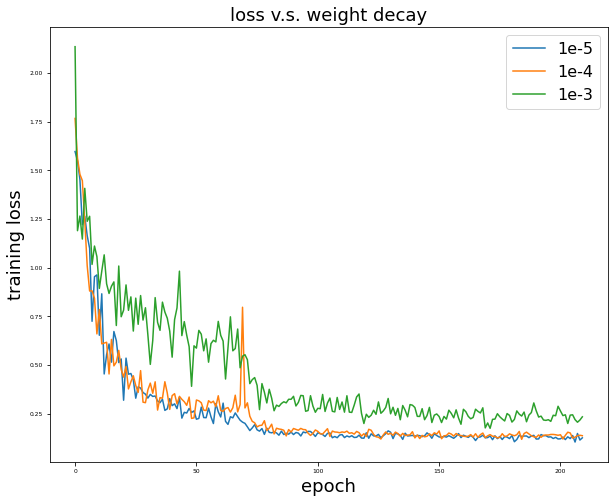

In [ ]:
# 'loss', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'
loss_category = 'loss'
# prefix_3 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_20_2020", "lr_0.005")
# loss_3 = np.loadtxt(prefix_3 + '/' + loss_category + '.txt')
# plt.plot(np.arange(len(loss_3)), loss_3, label="5e-3")

prefix_5 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_25_2020_wd_5", "loss_history")
loss_5 = np.loadtxt(prefix_5 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_5)), loss_5, label="1e-5")

prefix_4 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_23_2020", "loss_history")
loss_4 = np.loadtxt(prefix_4 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_4)), loss_4, label="1e-4")

prefix_3 = os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_25_2020", "loss_history")
loss_3 = np.loadtxt(prefix_3 + '/' + loss_category + '.txt')
plt.plot(np.arange(len(loss_3)), loss_3, label="1e-3")

plt.legend(loc="upper right", prop={'size': 16})
plt.xlabel("epoch", size=18)
plt.ylabel("training loss", size=18)
plt.title("loss v.s. weight decay", size=18)

## ***Evaluate the model***

For quick tests.
Now that training has finished, let's have a look at what it actually predicts in a test image.

In [ ]:
# pick one image from the test set
# for now the samples do not have empty predictions: 19, 15
# device = 'cuda'
img, target = dataset_test[19]
print(target['image_id'])
# img = Image.open(os.path.join(GOOGLE_DRIVE_COLAB_PATH, 'test.png'))
# img = np.array(img)
# img = torch.tensor(img)
# img = torchvision.transforms.functional.to_tensor(img)
# img, _ = dataset[29]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

tensor([50])


In [ ]:
# ret = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
# plt.axis('off')
# plt.imshow(ret, cmap='gray')

fig, ax = plt.subplots(5, 1, figsize=(20, 20))

i = 0
for row in ax:
  ret = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
  row.imshow(ret, cmap='gray', aspect='equal')
  label = prediction[0]["labels"][i]
  row.title.set_text(f'masks {i} {label}')
  row.axis('off')
  i += 1

plt.show()

Define a bunch of mask visualization functions.

In [ ]:
def plot_mask_prediction(idx, plot=True, mode='test'):
  if mode == 'test':
    img, target = dataset_test[idx]
  else:
    img, target = dataset[idx]

  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])

  num_instances = prediction[0]['masks'].shape[0]
  print('num_instances', num_instances)
  actual_num_instances = target['boxes'].shape[0]
  print('actual_num_instances', actual_num_instances)
  if plot:
    if (num_instances+1) % 2 == 0:
      fig, ax = plt.subplots((num_instances+1)//2, 2, figsize=(20, 20), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
      num_col = (num_instances+1)/2
    else:
      fig, ax = plt.subplots((num_instances+1)//2+1, 2, figsize=(20, 20), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
      num_col = (num_instances+1)//2+1

  src = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'images', str(int(target['image_id']+1)).zfill(8) + '.png'))

  if plot:
    ax[0][0].imshow(src)
    ax[0][0].title.set_text(f"ID: {int(target['image_id']+1)} #instance-pred/act: {num_instances}/{actual_num_instances}")
    ax[0][0].axis('off')
  count_1 = 0
  for i in range(num_instances):
    label = prediction[0]["labels"][i]
    if label == 1:
      count_1 += 1

    if plot:
      r = 1 if i+1 > num_col-1 else 0
      c = int((i+1) % num_col)
      row = ax[c][r]
      ret = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
      row.imshow(ret, cmap='gray', aspect='equal')
      
      row.title.set_text(f'instance: {i} label: {label} ')
      row.axis('off')

  if plot and (num_instances+1) % 2 != 0:
    fig.delaxes(ax[-1][1])

  # plt.rcParams['figure.figsize'] = (10.0, 8.0)
  # plt.rcParams['font.size'] = 10
  print(f'label 1 / num_instance_detected: {count_1}/{num_instances}')
  return fig

In [ ]:
def plot_mask_prediction_from_src(src):
  img = torchvision.transforms.functional.to_tensor(src)

  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])

  num_instances = prediction[0]['masks'].shape[0]
  print('num_instances', num_instances)
  if (num_instances+1) % 2 == 0:
    fig, ax = plt.subplots((num_instances+1)//2, 2, figsize=(20, 20), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
    num_col = (num_instances+1)/2
  else:
    fig, ax = plt.subplots((num_instances+1)//2+1, 2, figsize=(20, 20), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
    num_col = (num_instances+1)//2+1

  ax[0][0].imshow(src)
  # ax[0][0].title.set_text(f"ID: {int(target['image_id']+1)} #instance-pred/act: {num_instances}/{actual_num_instances}")
  ax[0][0].axis('off')
  for i in range(num_instances):
    r = 1 if i+1 > num_col-1 else 0
    c = int((i+1) % num_col)
    row = ax[c][r]
    ret = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
    row.imshow(ret, cmap='gray', aspect='equal')
    label = prediction[0]["labels"][i]
    row.title.set_text(f'instance: {i} label: {label} ')
    row.axis('off')

  if (num_instances+1) % 2 != 0:
    fig.delaxes(ax[-1][1])

  plt.rcParams['figure.figsize'] = (10.0, 8.0)
  plt.rcParams['font.size'] = 10
  return fig

In [ ]:
plot_mask_prediction(5)

Save mask_pred here.

In [ ]:
for i in range(len(dataset_test)):
  fig = plot_mask_prediction(i)
  fig.savefig(os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_25_2020_wd_5", 'mask_pred', str(i+1).zfill(3) + "_pred.png"))

Define a bunch of bounding box visualization functions.

In [24]:
def plot_bbox(idx):
  from matplotlib.pyplot import figure
  from matplotlib import colors
  img, target = dataset_test[idx]

  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])
  box_location = prediction[0]['boxes']

  print('image_id', target['image_id'])
  print("scores", prediction[0]['scores'])
  src = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'images', str(int(target['image_id']+1)).zfill(8) + '.png'))
  fig, ax = plt.subplots(1, 2, figsize=(20, 20), gridspec_kw={'hspace': 0.2, 'wspace': 0.01})

  ax[0].imshow(src)
  ax[0].axis('off')
  color_list = ['m', 'y', 'w','tab:orange', 
                'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 
                'tab:gray', 'bisque', 'darkred', 'olive',
                'lavender', 'plum', 'magenta', 'deeppink', 'indigo',
                'salmon', 'coral']

  for i in range(box_location.shape[0]):
    if prediction[0]['scores'][i] > 0.95:
      width = box_location[i][2] - box_location[i][0]
      height = box_location[i][3] - box_location[i][1]
      if prediction[0]['labels'][i] == 1:
        rect = patches.Rectangle((box_location[i][0]-1, box_location[i][1]-1), width, height, linewidth=3, edgecolor='g', facecolor='none')
      else:
        rect = patches.Rectangle((box_location[i][0]-1, box_location[i][1]-1), width, height, linewidth=3, edgecolor='r', facecolor='none')
      ax[0].add_patch(rect)
      text_str = 'crop' if prediction[0]['labels'][i] == 1 else 'weed'
      score = prediction[0]['scores'][i]
      text_str += ' %2.3f' %(score)
      ax[0].text(box_location[i][0]-1, box_location[i][3]-1, text_str, size=15, color='white')

      # plot transparent mask
      mask_i = (prediction[0]['masks'][i, 0] > 0.2).mul(1).byte().cpu().numpy()
      mask_equals_1 = (mask_i == 1)
      mask_i = np.zeros_like(mask_i) * np.nan
      rand_int = np.random.randint(0, len(color_list))
      # print('rand', rand_int)
      mask_i[mask_equals_1] = 1
      ax[0].imshow(mask_i, alpha=0.5, cmap=colors.ListedColormap(color_list[rand_int]))
  

  # semantic = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'annotations', str(target['image_id'].item()+1).zfill(3) + '_annotation.png'))
  # ax[1].imshow(semantic)
  # ax[1].axis('off')

  # ax[2].imshow((prediction[0]['masks'][1, 0] > 0.2).mul(1).byte().cpu().numpy(), cmap='gray',)
  return fig
  # return target['image_id']

In [43]:
def plot_bbox_from_src(src):
  from matplotlib import colors
  img = torchvision.transforms.functional.to_tensor(src)

  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])
  box_location = prediction[0]['boxes']

  fig, ax = plt.subplots(1)
  # print('boxes location', box_location, box_location.shape) # xmin ymin xmax ymax
  color_list = ['m', 'tab:orange', 'b',
                'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 
                'bisque', 'hotpink', 'olive', 'blueviolet',
                'orange', 'plum', 'magenta', 'deeppink', 'indigo',
                'salmon', 'orchid']
  ax.imshow(src)
  ax.axis('off')
  for i in range(box_location.shape[0]):
    if prediction[0]['scores'][i] > 0.95:
      width = box_location[i][2] - box_location[i][0]
      height = box_location[i][3] - box_location[i][1]
      rect = patches.Rectangle((box_location[i][0]-1, box_location[i][1]-1), width, height, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      text_str = 'crop' if prediction[0]['labels'][i] == 1 else 'weed'
      score = prediction[0]['scores'][i]
      text_str += ' %2.2f' %(score)
      ax.text(box_location[i][0]-1, box_location[i][3]-1, text_str, size=15, color='white')

      # plot transparent mask
      mask_i = (prediction[0]['masks'][i, 0] > 0.01).mul(1).byte().cpu().numpy()
      mask_equals_1 = (mask_i == 1)
      mask_i = np.zeros_like(mask_i) * np.nan
      rand_int = np.random.randint(0, len(color_list))
      # print('rand', rand_int)
      mask_i[mask_equals_1] = 1
      ax.imshow(mask_i, alpha=0.5, cmap=colors.ListedColormap(color_list[rand_int]))
  
  return fig

Test bbox plot with transparent masks.

In [ ]:
plot_bbox(11)

Save bbox_pred here.

In [ ]:
for i in range(20):
  fig = plot_bbox(i)
  fig.savefig(os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_29_2020", 'score_filtered_results_with_tsp_mask', str(i+1).zfill(3) + "_pred.png"))

Test real garden pictures.

In [ ]:
img = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'garden_images', '8'.zfill(3) + '_test.jpg'))
img = torchvision.transforms.functional.to_tensor(img)

model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

num_instances = prediction[0]['masks'].shape[0]
ret = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
plt.imshow(ret, cmap='gray', aspect='equal')

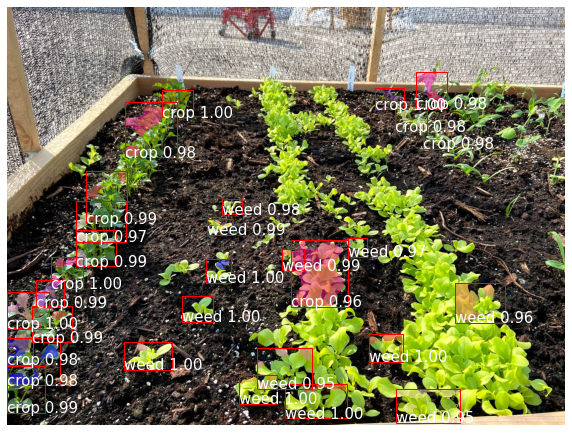

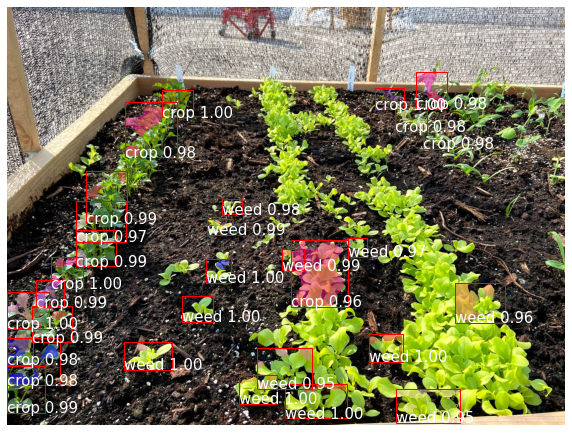

In [44]:
# img = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'garden_images', '1'.zfill(3) + '_test.jpg'))
img = Image.open("/content/drive/MyDrive/directed_study_Yuliang_Zhu/dataset/CWFID/dataset-1.0/garden_images/003_test.jpg")
# img = torchvision.transforms.functional.to_tensor(img)

# model.eval()
# with torch.no_grad():
#   prediction = model([img.to(device)])

# num_instances = prediction[0]['masks'].shape[0]
# ret = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
# plt.imshow(ret, cmap='gray', aspect='equal')
plot_bbox_from_src(img)

In [ ]:
for i in range(8):
  img = Image.open(os.path.join(GOOGLE_DRIVE_DATASET_PATH, 'garden_images', str(i+1).zfill(3) + '_test.jpg'))
  fig = plot_bbox_from_src(img)
  fig.savefig(os.path.join(GOOGLE_DRIVE_PRED_PATH, "11_29_2020", 'garden_pred', str(i+1).zfill(3) + "_pred.png"))

Output hidden; open in https://colab.research.google.com to view.

Let's make a cell that plots the comprehensive result of the prediction on the test dataset.